<a href="https://colab.research.google.com/github/Claptar/rnaseq_mipt/blob/main/notebooks/differential_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка окружения

## Скачаем необходимые библиотеки

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("edgeR")

install.packages("ggplot2")
install.packages("pheatmap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Installing package(s) 'BiocVersion', 'edgeR'

also installing the dependencies ‘statmod’, ‘limma’, ‘locfit’, ‘Rcpp’


Old packages: 'bit', 'bslib', 'callr', 'curl', 'data.table', 'DBI', 'dbplyr',
  'devtools', 'digest', 'gargle', 'ggplot2', 'highr', 'htmltools', 'isoband',
  'openssl', 'pkgbuild', 'processx', 'ragg', 'remotes', 'rmarkdown',
  'rstudioapi', 'rvest', 'sass', 'systemfonts', 'textshaping', 'tidyselect',
  'tinytex', 'usethis', 'whisker', 'xfun', 'zip', 'lattice', 'nlme'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

In [2]:
library(edgeR)
library(ggplot2)

Loading required package: limma



## Подгрузим наши данные

Файл с каунтами: [ссылка](https://github.com/Claptar/rnaseq_mipt/blob/main/results/counts.csv)

In [3]:
expression <- read.csv('counts.csv', header=TRUE, row.names=1)
head(expression)

,SRR3414631,SRR3414630,SRR3414636,SRR3414637,SRR3414635,SRR3414629
,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000064341,57039,43493,51029,63237,52101,45624
ENSMUSG00000064345,43560,32273,31116,34681,31629,33351
ENSMUSG00000064351,113347,75750,76672,87061,78155,86348
ENSMUSG00000064354,45,36,22,39,36,26
ENSMUSG00000064356,3,1,3,0,4,5
ENSMUSG00000064357,32,18,17,16,27,19


In [14]:
annotation <- matrix(c("reprog", "reprog", "ctrl", "ctrl", "ctrl", "reprog"))
rownames(annotation) <-colnames(expression)
colnames(annotation) <- c("condition")
annotation <- data.frame(annotation)
annotation$condition <- factor(annotation$condition, levels=c("ctrl", "reprog"))
annotation

,condition
,<fct>
SRR3414631,reprog
SRR3414630,reprog
SRR3414636,ctrl
SRR3414637,ctrl
SRR3414635,ctrl
SRR3414629,reprog


# Предобработка

In [15]:
y <- DGEList(counts=expression, samples=annotation)

Фильтрация

In [16]:
keep.genes <- filterByExpr(y, group=y$samples$condition)
table(keep.genes)

keep.genes
FALSE  TRUE 
 8210 13481 

In [17]:
y <- y[keep.genes, , keep=FALSE]

In [18]:
y <- normLibSizes(y)
head(y$samples, n=10L)

,group,lib.size,norm.factors,condition
,<fct>,<dbl>,<dbl>,<fct>
SRR3414631,1,18230901,1.0483659,reprog
SRR3414630,1,11338801,1.0403518,reprog
SRR3414636,1,15611273,0.9631441,ctrl
SRR3414637,1,15566280,0.9559073,ctrl
SRR3414635,1,16118146,0.9639852,ctrl
SRR3414629,1,15875614,1.0330693,reprog


In [19]:
write.csv(cpm(y, log=FALSE, normalized.lib.sizes=TRUE), 'tmm_edgeR.csv')

In [20]:
summary(y$samples$norm.factors)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9559  0.9634  0.9985  1.0008  1.0385  1.0484 

# Data exploration

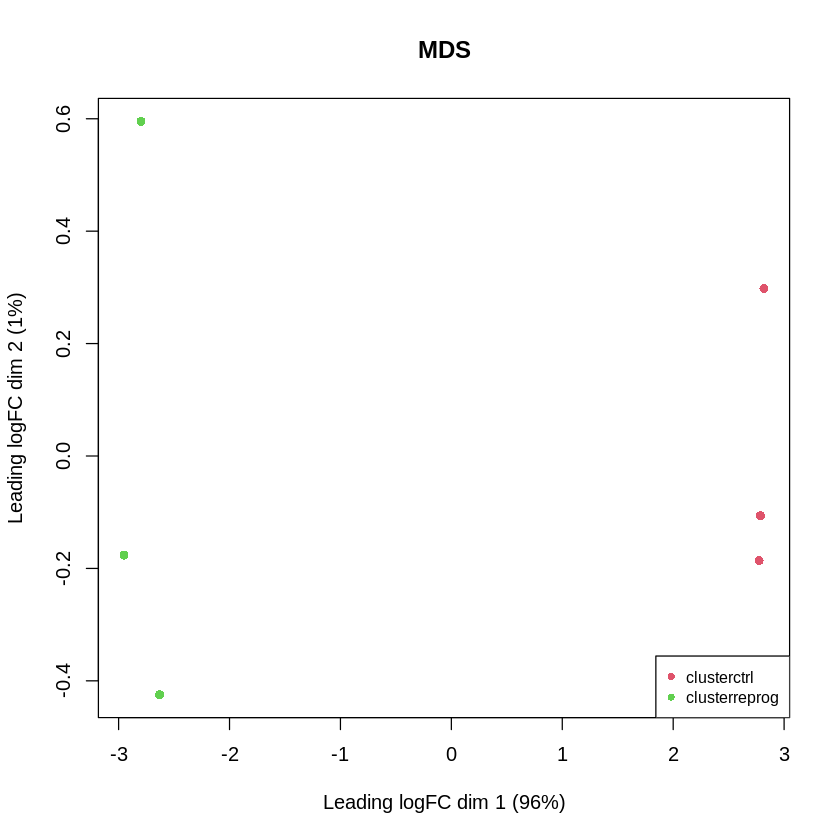

In [22]:
condition <- as.factor(y$samples$condition)
plotMDS(y, pch=16, col=c(2:3)[condition], main="MDS")
legend("bottomright", legend=paste0("cluster",levels(condition)), pch=16, col=2:3, cex=0.8)

Образцы хорошо разделяются

# Differential expression

## Design matrix

In [24]:
design <- model.matrix(~ condition)
colnames(design) <- gsub("condition", "", colnames(design))
head(design)

,(Intercept),reprog
1,1,1
2,1,1
3,1,0
4,1,0
5,1,0
6,1,1


## Estimate dispersion

In [25]:
y <- estimateDisp(y, design, robust=TRUE)
y$common.dispersion

[1] 0.009731026

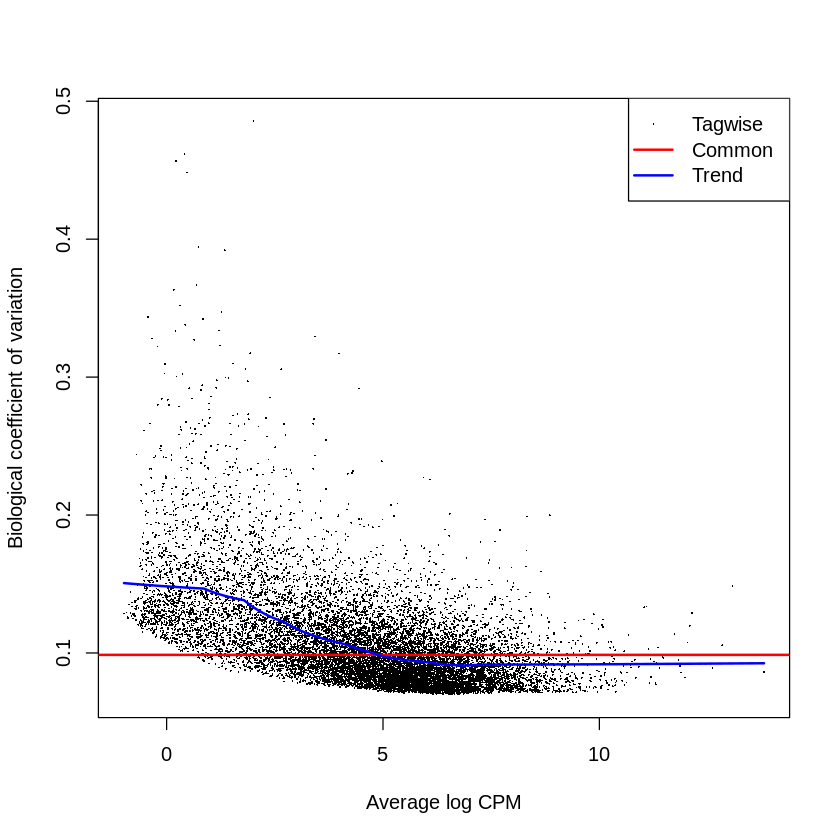

In [26]:
plotBCV(y)

In [27]:
fit <- glmFit(y, design)

## Estimate parameters

In [34]:
lrt <- glmLRT(fit, coef=2)
topTags(lrt, n = 30)$table

,logFC,logCPM,LR,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000035557,11.806160,8.528377,2806.545,0.000000e+00,0.000000e+00
ENSMUSG00000102308,11.038127,5.780197,1657.367,0.000000e+00,0.000000e+00
ENSMUSG00000092586,10.912516,7.289780,1580.148,0.000000e+00,0.000000e+00
ENSMUSG00000049382,10.820563,8.590946,2279.240,0.000000e+00,0.000000e+00
ENSMUSG00000044294,10.718822,5.968469,1870.130,0.000000e+00,0.000000e+00
ENSMUSG00000047501,10.207945,6.587246,1631.070,0.000000e+00,0.000000e+00
ENSMUSG00000041782,9.660380,5.830699,1486.707,0.000000e+00,0.000000e+00
ENSMUSG00000048699,9.565425,7.336693,2311.292,0.000000e+00,0.000000e+00
ENSMUSG00000045545,9.104124,8.072739,2829.382,0.000000e+00,0.000000e+00


In [35]:
write.csv(topTags(lrt, n = Inf)$table, file="de_results.csv")

In [41]:
summary(decideTestsDGE(lrt))

       reprog
Down     4040
NotSig   5185
Up       4256